#### This notebook is created on Kaggle, you can import this notebook and run it there without having any trouble.

author: [@caesariodito](https://github.com/caesariodito)

# Setup

In [41]:
from IPython.display import clear_output as cls

In [100]:
# character recognition data - personal fixed
# https://drive.google.com/file/d/1PbNh3sixd4w-UDdPN-adeTj9HZMUvP04/view?usp=sharing

!pip install gdown

import zipfile

!rm -r dataset
!gdown "https://drive.google.com/uc?id=1PbNh3sixd4w-UDdPN-adeTj9HZMUvP04" -O dataset.zip
# !unzip dataset.zip -d dataset
with zipfile.ZipFile('/kaggle/working/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/dataset')

cls()

In [43]:
# common
import os
import numpy as np
import tensorflow as tf
import typing
from tensorflow import keras
from typing import Tuple, List
from tqdm import tqdm
from glob import glob
from datetime import datetime

# preprocessing
from tensorflow import image as tfi
# from sklearn.model_selection import train_test_split

# architecture
from tensorflow.keras import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

# visualization
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model

# Model Training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

cls()

In [44]:
train_dir = '/kaggle/working/dataset/balanced/train/'
val_dir = '/kaggle/working/dataset/balanced/valid/'
test_dir = '/kaggle/working/dataset/balanced/test/'

In [45]:
# Constants

HEIGHT_SIZE = 160
WIDTH_SIZE = 80
BATCH_SIZE = 32
EPOCHS = 10
# EPOCHS = 1


LEARNING_RATE = 1e-4
# LEARNING_RATE = 1e-3


LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
METRICS = ['accuracy']

# callback
EARLYSTOP_PATIENCE = 3


# Random Seed
random_seed = 42 # set random seed for reproducibility
tf.random.set_seed(random_seed) # set random seed for TensorFlow
np.random.seed(random_seed) # set random seed for NumPy

In [46]:
# Collect the class names
class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)

# Functions

In [65]:
def load_and_preprocess_image(image, label):
    # Resize the image to the desired size
    image = tf.image.resize(image, [HEIGHT_SIZE, WIDTH_SIZE])
    
    # Rescale pixel values to be in the range [0, 1]
#     image = tf.image.per_image_standardization(image)
    
    # Convert image data type to tf.float32
    image = tf.cast(image, tf.float32)
    
    return image, label

In [84]:
def plot_images(dataset: tf.data.Dataset, n_rows: int = 5, n_cols: int = 4, class_names=class_names, figsize=(20, 20), model=None, check=False):
    """
    Plots a grid of images and their corresponding labels from a tf.data.Dataset object.

    Args:
        dataset (tf.data.Dataset): A TensorFlow dataset object containing the images and labels to plot.
        n_rows (int): Number of rows in the plot grid. Default is 5.
        n_cols (int): Number of columns in the plot grid. Default is 4.
        class_names (list): A list of strings mapping the integer labels to their corresponding class names. Default is None.
        figsize (tuple): A tuple specifying the size of the figure. Default is (20, 20).
        model (tf.keras.Model): A trained TensorFlow model to make predictions on the images. Default is None.
        check (bool): If True and a model is provided, only incorrectly predicted images will be plotted. Default is False.
    """
    
    # Create a figure to display the images
    fig = plt.figure(figsize=figsize)
    
    # Initialize image counter
    image_count = 0
    
    # Loop over all batches in dataset
    for images, labels in dataset:
        
        # Loop over all images in batch
        for i in range(images.shape[0]):
            
            label = int(labels[i].numpy())
            title = "true: "+class_names[label]

            if model:
                pred = model.predict(images[i][np.newaxis], verbose=0)

                if check:
                    if label == np.argmax(pred):
                        continue

                pred_label = f"Pred: {np.argmax(pred)}"
                pred_percentage = f" ({np.max(pred) * 100:.2f}%)"
                if class_names:
                    pred_label += f" ({class_names[np.argmax(pred)]})"
                title += f"\n{pred_label} {pred_percentage}"

            # Create a subplot for each image
            ax = fig.add_subplot(n_rows, n_cols, image_count+1)    

            # Plot the image
            ax.imshow(images[i].numpy().astype("uint8"))

            # Set the title to the corresponding label
            ax.set_title(title)

            # Remove the axis ticks
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Increment image counter
            image_count += 1
            
            # Check if maximum number of images has been reached
            if image_count >= n_rows * n_cols:
                break
        
        # Check if maximum number of images has been reached
        if image_count >= n_rows * n_cols:
            break
    
    # Show the plot
    plt.show()

In [52]:
def timer(start_time: datetime = None) -> "typing.Union[datetime.datetime, str]":
    """
    Measures the time elapsed from a given start time.

    If no start time is provided, returns the current time. If a start time is provided, returns a formatted string
    representing the time elapsed from the start time to the current time.

    Args:
        start_time (datetime.datetime, optional): The start time to measure elapsed time from, or None to get the current time. Defaults to None.

    Returns:
        Union[datetime.datetime, str]: The current time if no start time is provided, or a formatted string representing the elapsed time.
    """
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        return "%i hours %i minutes and %s seconds." % (
            thour,
            tmin,
            round(tsec, 2),
        )

In [53]:
def plot_history(history, test_loss, test_acc, model_name):
    # Collect the history of the training run
    history_plot = pd.DataFrame(history.history)
    
    # Create a figure to display the model's performance
    plt.figure(figsize=(20, 5))

    # Plot the loss curve in the first subplot
    plt.subplot(1, 2, 1)
    plt.title(f"{model_name} - Loss Curve")
    plt.plot(history_plot['loss'], label="Training Loss")
    plt.plot(history_plot['val_loss'], label="Validation Loss")

    # Horizontal line to show the testing performance
    plt.axhline(y=test_loss, label="Test Loss", linestyle='--', color='green')

    # Set the x- and y-labels, and the x- and y-limits
    plt.xlabel("Epochs")
    plt.ylabel("Cross Entropy Loss")
    # plt.ylim([0, 0.4])

    # Show the legend and grid
    plt.legend()
    plt.grid()

    # Plot the accuracy curve in the second subplot
    plt.subplot(1, 2, 2)
    plt.title(f"{model_name} - Accuracy Curve")
    plt.plot(history_plot['accuracy'], label="Training Accuracy")
    plt.plot(history_plot['val_accuracy'], label="Validation Accuracy")

    # Horizontal line to show the testing performance
    plt.axhline(y=test_acc, label="Test Accuracy", linestyle='--', color='green')

    # Set the x- and y-labels, and the x- and y-limits
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    # plt.ylim([0.85, 1])

    # Show the legend and grid
    plt.legend()
    plt.grid()

    # Display the plot
    plt.show()

In [54]:
def plot_confusion_m(y_true, y_pred, class_names=None, figsize=(15,15)):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Data Prep

In [55]:
# Show
print(f"Total number of classes in train: {n_classes}")
print(f"Classes: {class_names}")

Total number of classes in train: 36
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


# Create Dataset

In [101]:
# del train_ds, val_ds, test_ds
# del train_ds_mapped, val_ds_mapped, test_ds_mapped

# Create a dataset from the data directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, batch_size=BATCH_SIZE
)

Found 22526 files belonging to 36 classes.
Found 1116 files belonging to 36 classes.
Found 1368 files belonging to 36 classes.


## preprocessing

In [102]:
train_ds_mapped = train_ds.map(load_and_preprocess_image)
val_ds_mapped = val_ds.map(load_and_preprocess_image)
test_ds_mapped = test_ds.map(load_and_preprocess_image)

train_ds_mapped.prefetch(tf.data.AUTOTUNE)
val_ds_mapped.prefetch(tf.data.AUTOTUNE)
test_ds_mapped.prefetch(tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 80, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Data Visualization

In [68]:
# Calculate class distribution
class_dis = [len(os.listdir(train_dir + name)) for name in class_names]
# class_dis = [len(os.listdir(val_dir + name)) for name in class_names]
# class_dis = [len(os.listdir(test_dir + name)) for name in class_names]

# Visualize using interactive pie chart
pie_chart = px.pie(values=class_dis, names=class_names, color=class_names)
pie_chart.update_layout({'title':{'text':"Class Distribution"}})
pie_chart.show()

# Visualize using interactive bar chart
bar_chart = px.bar(y=class_dis, x=class_names, color=class_names)
bar_chart.show()

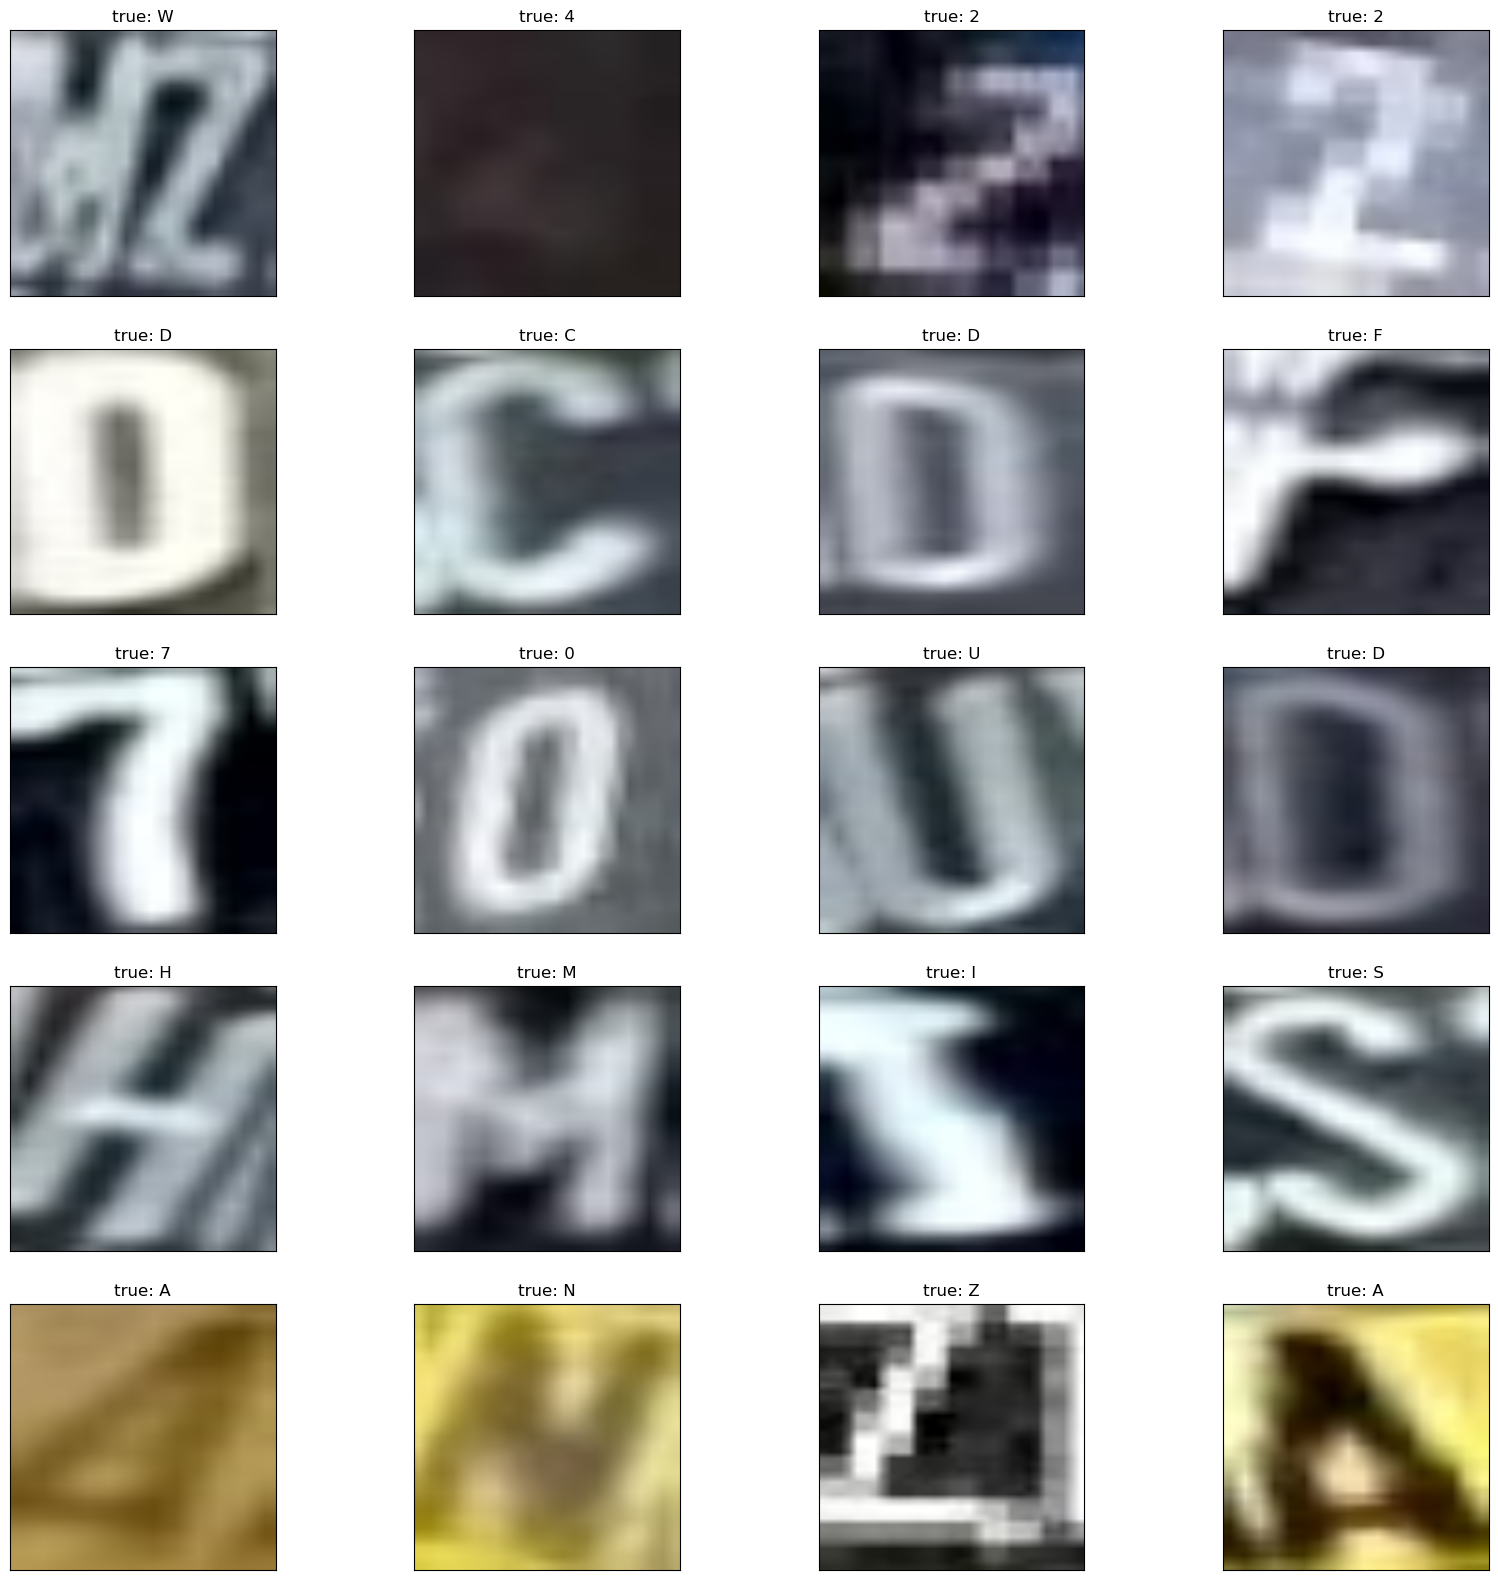

In [69]:
plot_images(train_ds)

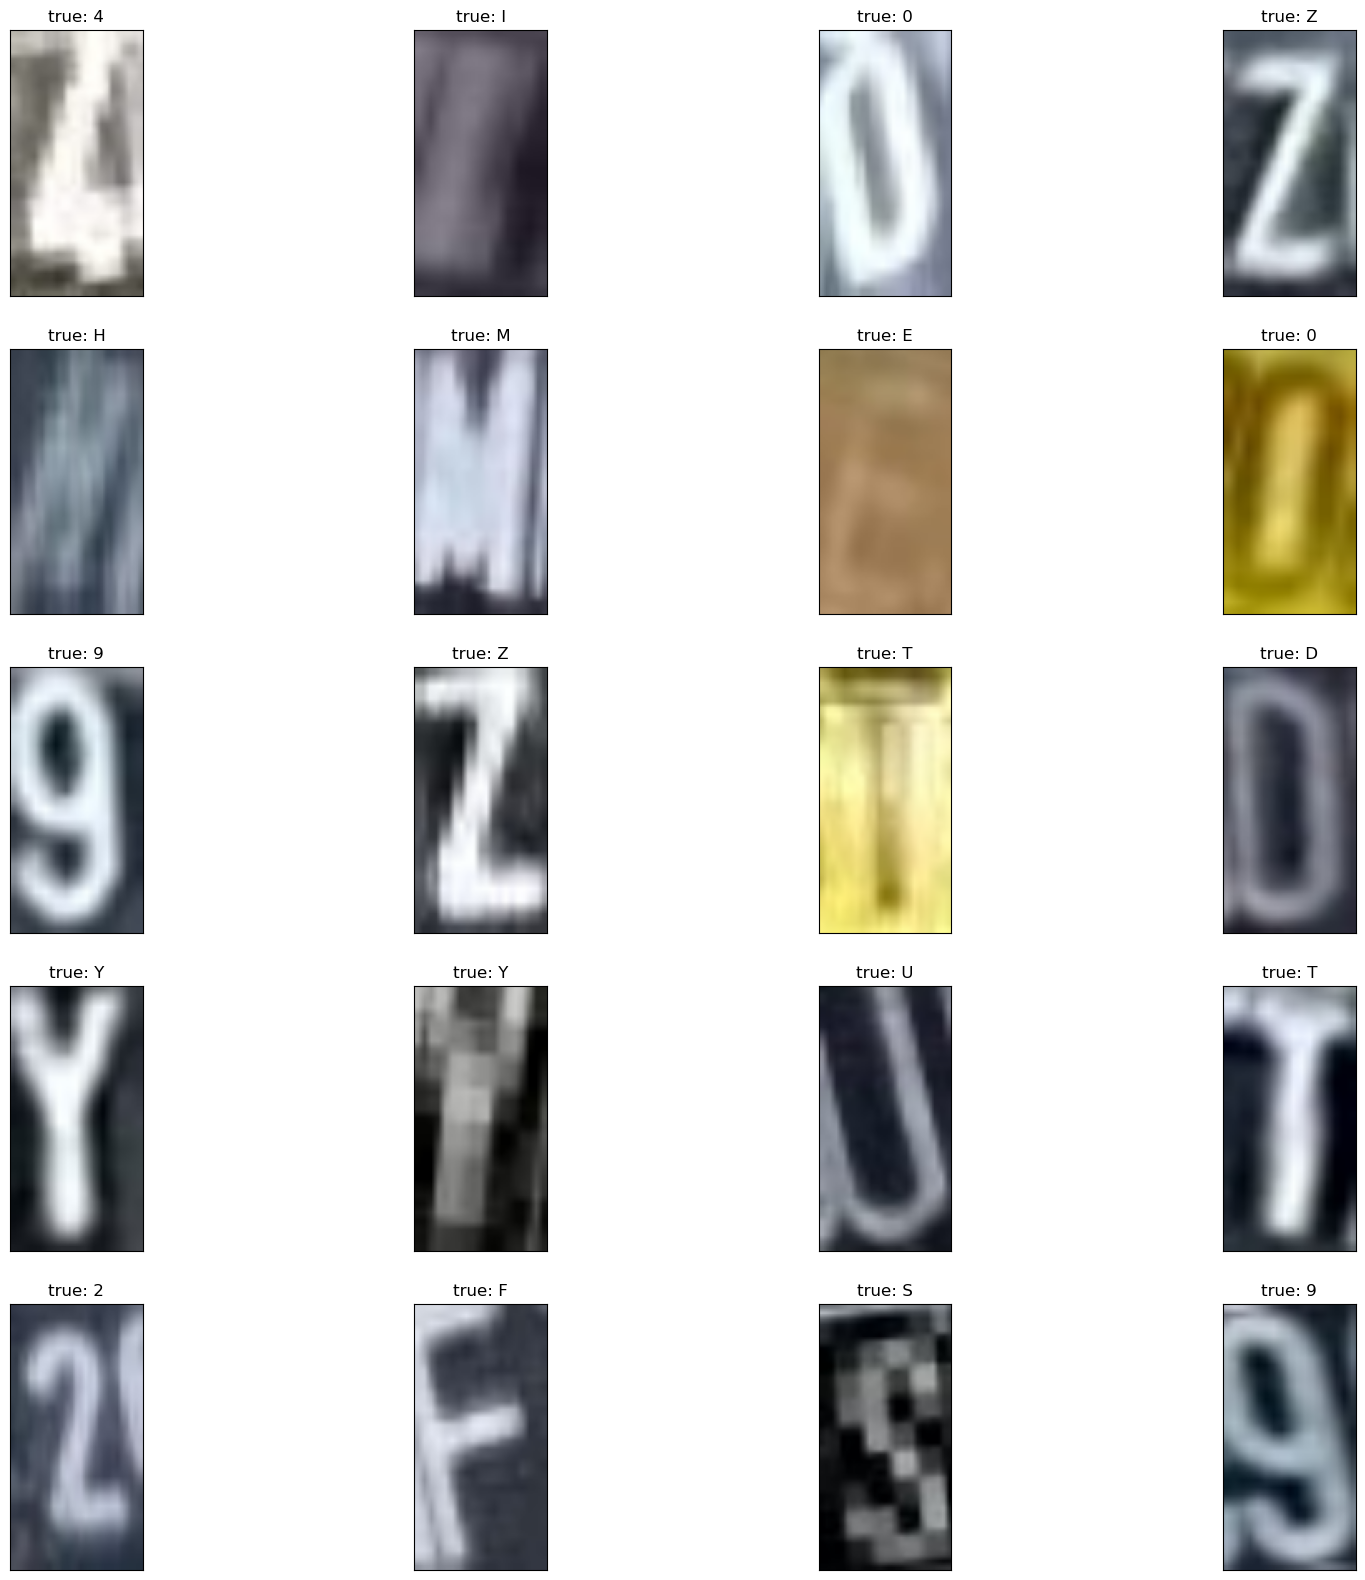

In [70]:
plot_images(train_ds_mapped)

# Model Building

In [87]:
# Download Xception

xception_full_train = Xception(input_shape=(HEIGHT_SIZE, WIDTH_SIZE, 3), weights='imagenet', include_top=False)
xception_full_train.trainable = True

# Model Summary

In [ ]:
# no freeze
name = 'character-recognition-alpr_xception_no_freeze_v1'

xception_transferred_no = Sequential([
    xception_full_train,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
], name=name)

xception_transferred_no.compile(
    loss=LOSS,
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS
)

xception_transferred_no.summary()

# Train No Freeze

In [90]:
print(f"\nTraining {xception_transferred_no.name}: ")

time = timer(None)
history_no = xception_transferred_no.fit(
    train_ds_mapped, 
    validation_data=val_ds_mapped, 
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(patience=EARLYSTOP_PATIENCE, restore_best_weights=True),
        ModelCheckpoint(f"checkpoint-{xception_transferred_no.name}.h5", save_best_only=True)
    ],
    batch_size=BATCH_SIZE,
)
time_taken = timer(time)
print(time_taken)


Training character-recognition-alpr_xception_no_freeze_v1: 
Epoch 1/10
704/704 [==============================] - 97s 97ms/step - loss: 0.9357 - accuracy: 0.7644 - val_loss: 0.2129 - val_accuracy: 0.9391
Epoch 2/10
704/704 [==============================] - 69s 98ms/step - loss: 0.0791 - accuracy: 0.9812 - val_loss: 0.1749 - val_accuracy: 0.9624
Epoch 3/10
704/704 [==============================] - 69s 97ms/step - loss: 0.0372 - accuracy: 0.9907 - val_loss: 0.1705 - val_accuracy: 0.9624
Epoch 4/10
704/704 [==============================] - 68s 96ms/step - loss: 0.0306 - accuracy: 0.9917 - val_loss: 0.2402 - val_accuracy: 0.9471
Epoch 5/10
704/704 [==============================] - 66s 94ms/step - loss: 0.0250 - accuracy: 0.9932 - val_loss: 0.2523 - val_accuracy: 0.9561
Epoch 6/10
704/704 [==============================] - 68s 96ms/step - loss: 0.0187 - accuracy: 0.9950 - val_loss: 0.2235 - val_accuracy: 0.9552
0 hours 7 minutes and 29.55 seconds.


# Evaluate

In [92]:
print('\nno freeze')
test_loss_n, test_acc_n = xception_transferred_no.evaluate(test_ds_mapped)
print("Loss    : {:.4}".format(test_loss_n))
print("Accuracy: {:.4}%".format(test_acc_n*100))


no freeze
8/8 [==============================] - 0s 29ms/step - loss: 0.4838 - accuracy: 0.8945
Loss    : 0.4838
Accuracy: 89.45%


# Graph

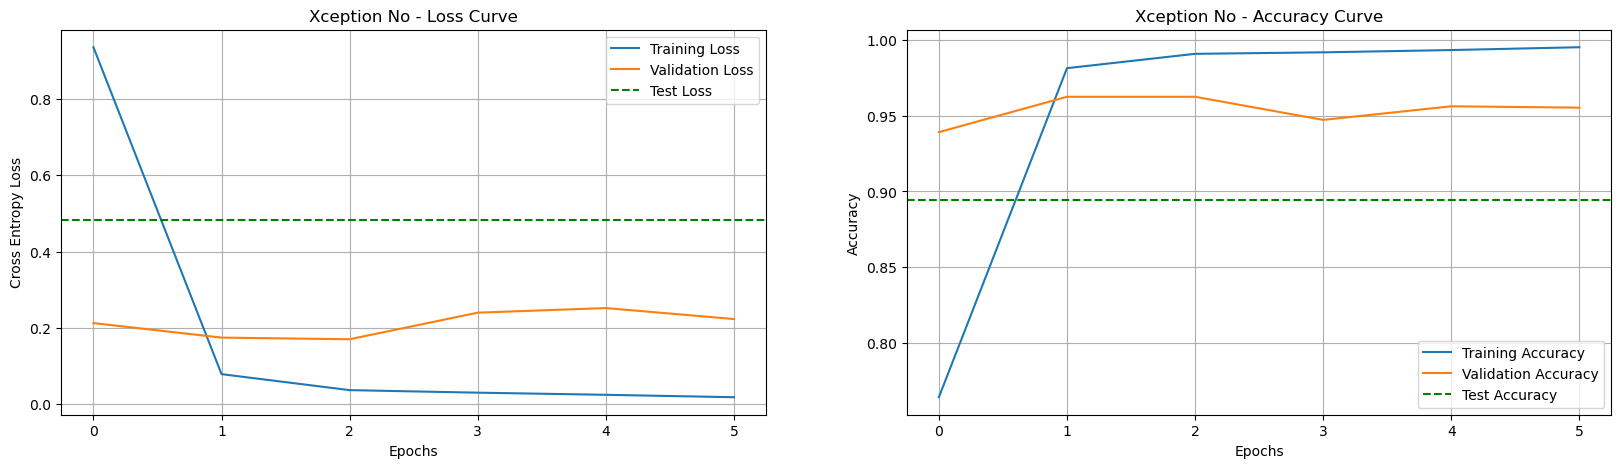

In [93]:
plot_history(history_no, test_loss_n, test_acc_n, 'Xception No')

# Confusion Matrix

In [103]:
y_f, y_h, y_n, = [], [], []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds_mapped:   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    
    # compute predictions
    preds_n = xception_transferred_no.predict(image_batch, verbose=0)
    
    # append predicted labels
    y_n.append(np.argmax(preds_n, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels_n = tf.concat([item for item in y_n], axis = 0)

cls()


no freeze


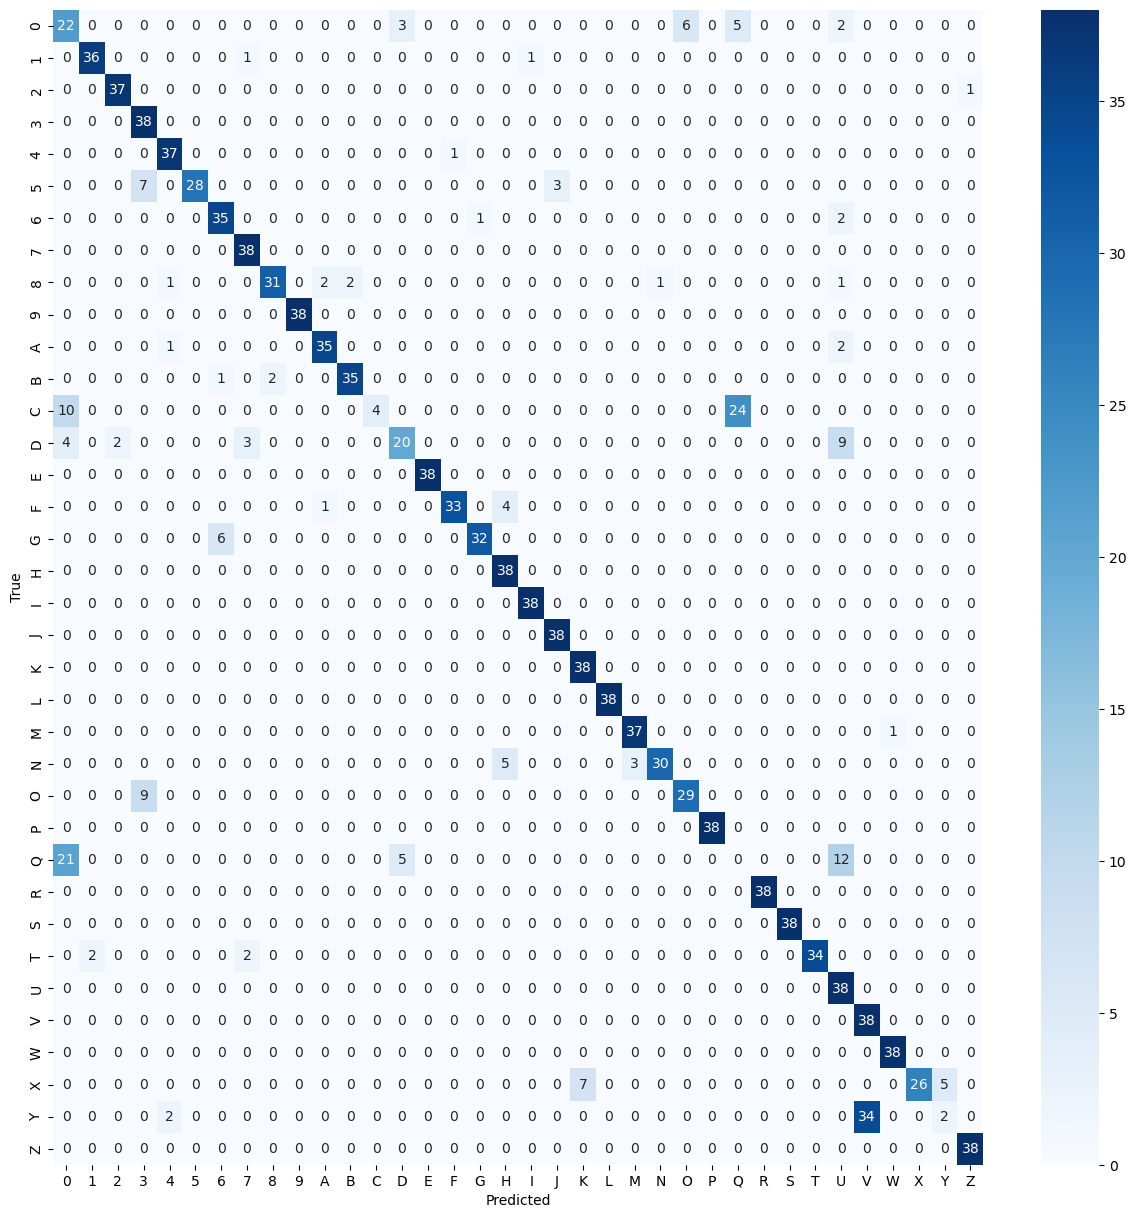

In [104]:
print('\nno freeze')
plot_confusion_m(correct_labels, predicted_labels_n, class_names)

# Prediction Visualization

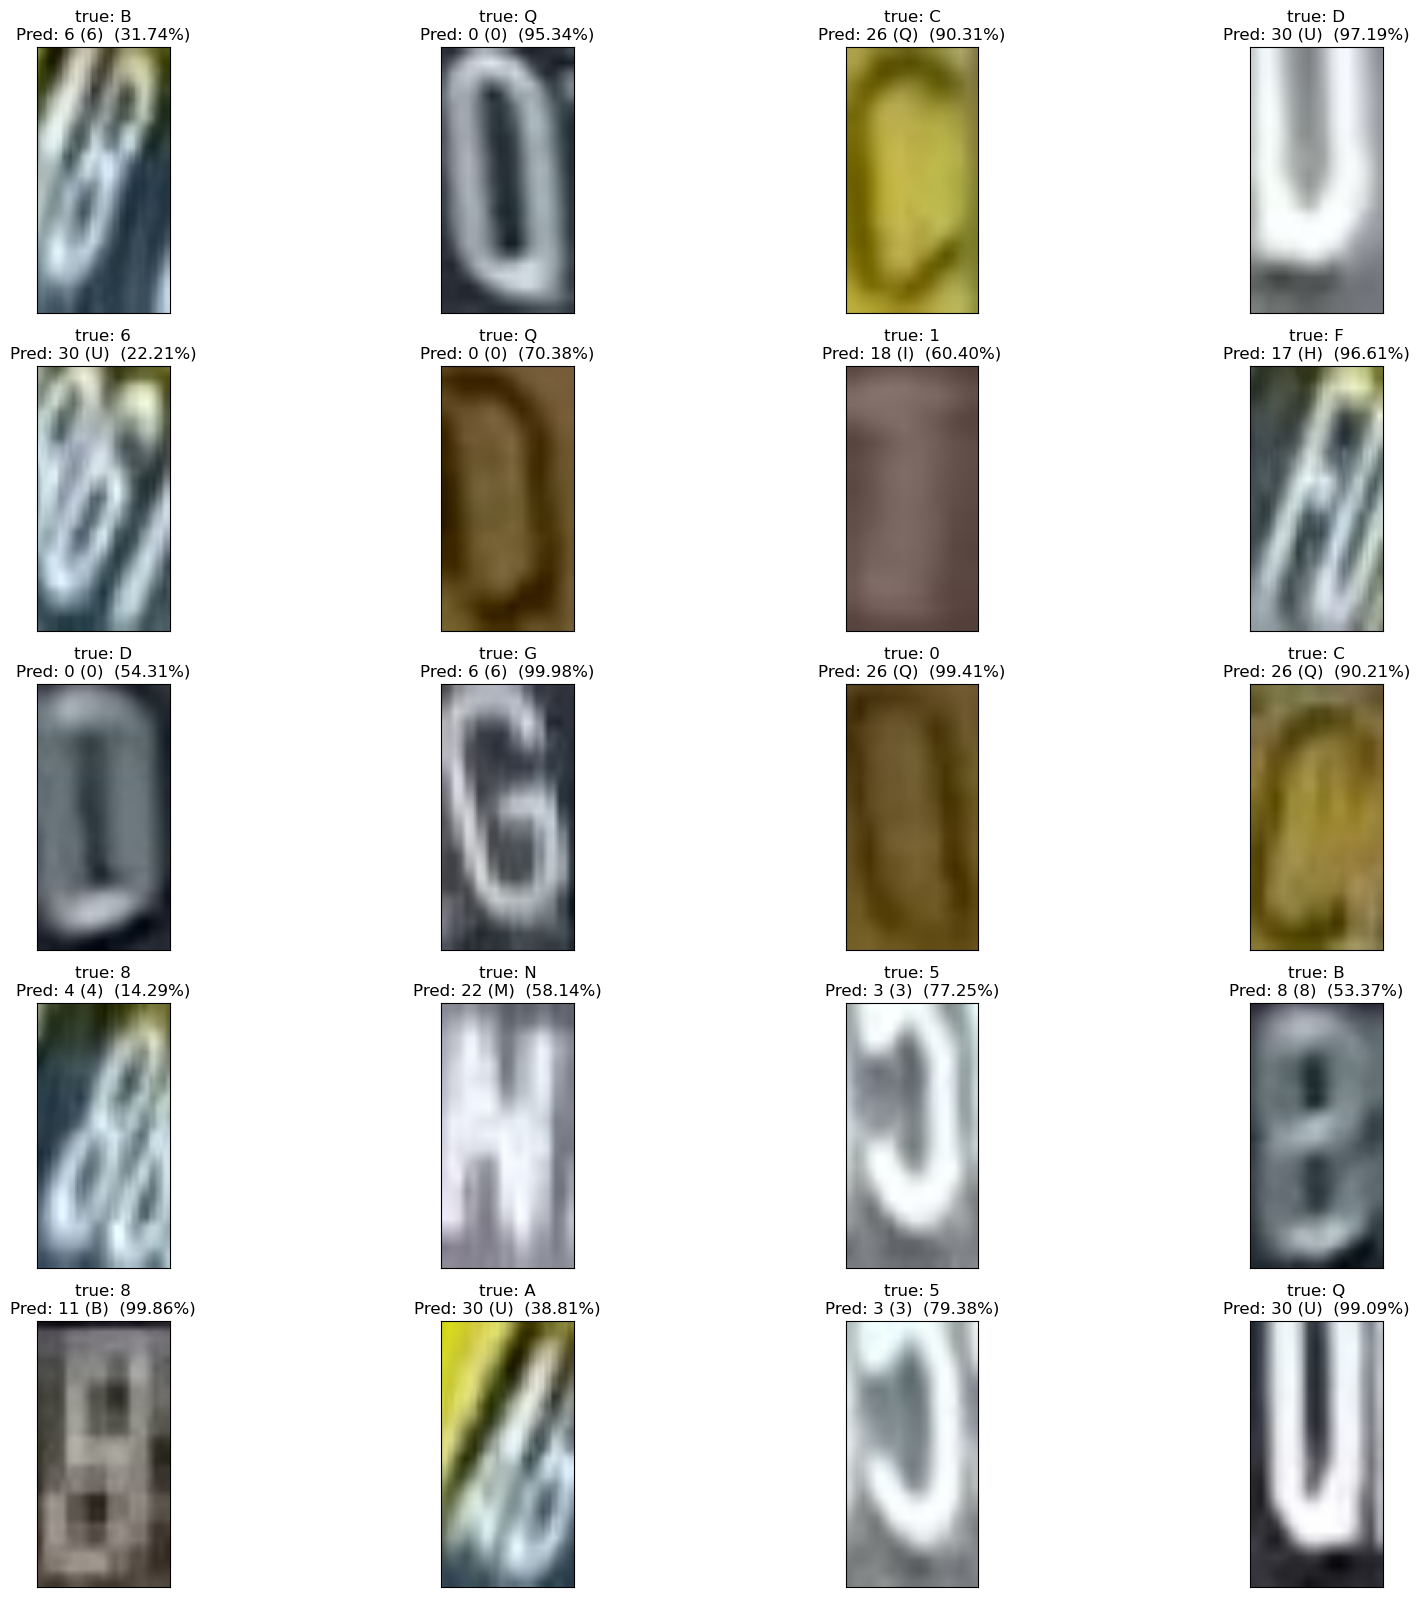

In [99]:
# show incorrect prediciton
plot_images(test_ds_mapped, model=xception_transferred_no, n_rows=5, check=True)

# Save Model

In [105]:
xception_transferred_no.save(xception_transferred_no.name+'.h5')

# Download Model

In [106]:
from IPython.display import FileLink
FileLink(xception_transferred_no.name+'.h5')

/kaggle/working/character-recognition-alpr_xception_no_freeze_v1.h5